# Bài tập về nhà môn thị giác máy
Nhận diện giới tính và dộ tuổi của em bé <10 tuổi
Tên sinh viên 
Nguyễn Bá Huy - MSSV:19146194                         

Notebook: này dùng để dự đoán độ tuổi                        
Mô tả :                                                 
Em chia quá trình training độ tuổi ra 3 stages                                         
* Ở trong Stage 1 :       
Em tiến hành training 3 khoảng tuổi, Stage 1 Em training ảnh với kích thước 200x200 và train ảnh xám                      
Qua nhiều lần modify và test real time Em thu được weights tốt nhất là file H5 :prednewmodel3.h5.
          
* Ở trong Stage 2:       
Em tiến hành training 4 khoảng tuổi, Stage 2 nEm training ảnh với kích thước 300x300  và train ảnh màu                      
Qua nhiều lần modify và test real time,em thu được weights tốt nhất là file H5 :last_experiment5_1_300x300.h5.

* Ở trong Stage 3:       
Em tiến hành kết hợp 2 model tuổi đã train ở stage 1 và stage 2 để chạy realtime

Stage 1 dataset: https://www.kaggle.com/datasets/tuanhcmute/agebabyv1  
Stage 2 dataset :https://www.kaggle.com/datasets/nguyenbahuy/experiment4l4/settings                                                                   

In [ ]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, Dropout, BatchNormalization

import matplotlib as plt
from keras.preprocessing.image import ImageDataGenerator 

# Gọi các thư viện cần thiết
from tensorflow.keras import layers,models
from sklearn.model_selection import train_test_split # Chia dữ liệu ra làm 2 phần


from keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop,SGD

import tensorflow as tf
import numpy as np
import cv2
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model

# SET UP
Chuẩn bị cho quá trình training mô hình

In [3]:
target_size=(300,300) #Kích thước ảnh đầu ra mong muốn
batch_size=32 #Số batch_size
directory="../input/experiment4l4" #Đường dẫn tới thư mục chứa hình ảnh 
num_classes=4 #Số lượng class đầu ra 
img_size=300 #Kích thước ảnh đưa vào train mô hình
learning_rate =0.002
momentum = 0.9
optimizer='adam'
loss='mse'
color_mode = 'rgb'
class_mode='categorical'
#Tạo một Dictionary  chứa một số phương pháp tăng tường ảnh mình muốn áp dụng cho tập training 
img_gen_args = dict(samplewise_center=False, 
                  samplewise_std_normalization=False, 
                  horizontal_flip = True, 
                  vertical_flip = True, 
                  height_shift_range = 0.05, 
                  width_shift_range = 0.02, 
                  rotation_range = 3, 
                  shear_range = 0.01,
                  rescale=1/255,
                  fill_mode = 'nearest',
                  validation_split=0.3,
                  zoom_range = 0.05,)

# Hàm con
Chia data thành tập train và tập validation    

In [1]:
def generate_data():
    # Preprocessing
    image_generator= ImageDataGenerator(**img_gen_args)

    train_dataset = image_generator.flow_from_directory(batch_size=batch_size,
                                                        directory=directory,color_mode = color_mode,
                                                        shuffle=True,
                                                        target_size=target_size, 
                                                        subset="training",
                                                        class_mode=class_mode)

    validation_dataset = image_generator.flow_from_directory(batch_size=batch_size,
                                                            directory=directory,color_mode = color_mode,
                                                            shuffle=True,
                                                            target_size=target_size, 
                                                            subset="validation",
                                                            class_mode=class_mode)
    return train_dataset,validation_dataset

# Chuẩn bị mô hình

In [17]:
def get_baseline_model(img_size,num_classes):
  
    visible = Input(shape=(img_size, img_size, 3), dtype=tf.float32)

    conv = Conv2D(32, (3, 3))(visible)
    conv_act = Activation('relu')(conv)
    conv_act_batch = BatchNormalization()(conv_act)
    conv_maxpool = MaxPooling2D()(conv_act_batch)
    conv_dropout = Dropout(0.1)(conv_maxpool)

    conv = Conv2D(64, (3, 3))(conv_dropout)
    conv_act = Activation('relu')(conv)
    conv_act_batch = BatchNormalization()(conv_act)
    conv_maxpool = MaxPooling2D()(conv_act_batch)
    conv_dropout = Dropout(0.2)(conv_maxpool)

    conv = Conv2D(128, (3, 3))(conv_dropout)
    conv_act = Activation('relu')(conv)
    conv_act_batch = BatchNormalization()(conv_act)
    conv_maxpool = MaxPooling2D()(conv_act_batch)
    conv_dropout = Dropout(0.3)(conv_maxpool)

    conv = Conv2D(256, (3, 3))(conv_dropout)
    conv_act = Activation('relu')(conv)
    conv_act_batch = BatchNormalization()(conv_act)
    conv_maxpool = MaxPooling2D()(conv_act_batch)
    conv_dropout = Dropout(0.1)(conv_maxpool)

    conv = Conv2D(512, (3, 3))(conv_dropout)
    conv_act = Activation('relu')(conv)
    conv_act_batch = BatchNormalization()(conv_act)
    conv_maxpool = MaxPooling2D()(conv_act_batch)
    conv_dropout = Dropout(0.5)(conv_maxpool)
    
    gap2d = GlobalAveragePooling2D()(conv_dropout)
    act = Activation('relu')(gap2d)
    batch = BatchNormalization()(act)
    dropout = Dropout(0.3)(batch)

    fc1 = Dense(256)(dropout)
    act = Activation('relu')(fc1)
    batch = BatchNormalization()(act)
    dropout = Dropout(0.1)(batch)

    # and a logistic layer
    predictions = Dense(num_classes, activation='softmax')(dropout)
    
    # Create model.
    model = tf.keras.Model(visible, predictions, name='baseline')

    return model


# Training model

In [20]:
#Khởi tạo tập train và tập valid
train_dataset,validation_dataset=generate_data()
#Xem label 
print(train_dataset.class_indices)
#Khởi tạo mô hình
model = get_baseline_model(img_size,num_classes)
# Hàm tối ưu 
model.compile(optimizer =optimizer,loss =loss , metrics = ['accuracy'])
#Training mô hình
history=model.fit(train_dataset,batch_size=batch_size,epochs=30,verbose=1,validation_data=validation_dataset)
# Lưu lại weights của mô hình
model.save('last_experiment5_2_300x300.h5')

Epoch 1/30
104/104 [==============================] - 30s 276ms/step - loss: 0.2099 - accuracy: 0.3926 - val_loss: 0.2661 - val_accuracy: 0.4032
Epoch 2/30
104/104 [==============================] - 21s 204ms/step - loss: 0.1698 - accuracy: 0.4884 - val_loss: 0.2602 - val_accuracy: 0.4032
Epoch 3/30
104/104 [==============================] - 21s 202ms/step - loss: 0.1458 - accuracy: 0.5636 - val_loss: 0.2055 - val_accuracy: 0.4605
Epoch 4/30
104/104 [==============================] - 21s 200ms/step - loss: 0.1289 - accuracy: 0.6144 - val_loss: 0.1793 - val_accuracy: 0.4633
Epoch 5/30
104/104 [==============================] - 21s 203ms/step - loss: 0.1195 - accuracy: 0.6452 - val_loss: 0.1730 - val_accuracy: 0.5494
Epoch 6/30
104/104 [==============================] - 21s 202ms/step - loss: 0.1124 - accuracy: 0.6636 - val_loss: 0.1896 - val_accuracy: 0.4280
Epoch 7/30
104/104 [==============================] - 20s 190ms/step - loss: 0.1047 - accuracy: 0.6933 - val_loss: 0.1146 - val_ac

# Test mô hình trên tập dữ liệu mới


In [ ]:
# vẽ lại quá trình học
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','Validation'])
plt.show()

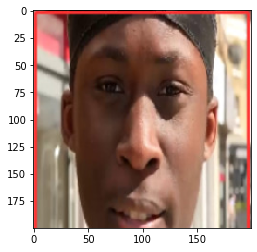

[[1.0727194e-05 7.3159190e-06 9.0326920e-02 9.0965509e-01]]
[3]
50-116


In [64]:
#Load weight vừa train
model=load_model('../input/experiment-weights/last_experiment5_1.h5')
import numpy as np
filename = "../input/predict-test/z3899771218576_18937b1d62edab3d7481d1e2c88aa3f0.jpg"

#{'1-3': 0, '11-50': 1, '4-6': 2, '50-116': 3, '7-10': 4}
#Load hình ảnh và show
img = load_img(filename,target_size=(200,200)) 
img_show = plt.imshow(img)
plt.show()
img = img_to_array(img)
#Reshape ảnh về (1,200,200,3) để đưa vào mô hình
img = img.reshape(1,200,200,3)
#Đưa datatype ảnh về dạng float để tính toán
img = img.astype('float32')
#Đưa ảnh về khoảng 0-1 normalize
img = img/255
#Dự đoán mô hình và show kết quả
result=model.predict(img)
kq= np.argmax(result,axis=1)
if(kq==0):
    print('1-3')
if(kq==1):
    print('11-50')
if(kq==2 ):
    print('4-6')
if(kq==3 ):
    print('50-116')
if(kq==4 ):
    print('7-10')